# Contact Analysis with abagpdb

This notebook demonstrates how to analyze molecular contacts (bonds) between protein structures using the `abagpdb` package.

## Overview

Contact analysis identifies interactions between different molecules or regions:
- **Hydrogen bonds**: Polar atom interactions (N, O, S)
- **Salt bridges**: Electrostatic interactions between charged residues
- **Hydrophobic contacts**: Nonpolar residue interactions
- **Disulfide bonds**: Cysteine-cysteine bridges
- **π-stacking**: Aromatic ring interactions

---

## Example: Antibody-Antigen Complex (PDB: 5GGS)

- **Chains H & L**: Antibody heavy and light chains
- **Chain A**: Antigen protein



## 1. Setup and Import


In [6]:
import abagpdb.contacts as contactanalysis
from abagpdb.pdbparser import parse_pdb

## 2. Load PDB Structure

In [7]:
cx = parse_pdb("5GGS_wt.pdb") 
print(f"✓ Loaded structure from: {cx.source_path}")
print(f"✓ Available chains: {list(cx.chains.keys())}")
print(f"✓ Total chains: {len(cx.chains)}")

✓ Loaded structure from: 5GGS_wt.pdb
✓ Available chains: ['A', 'H', 'L']
✓ Total chains: 3


## 3. Run Contact Analysis

Analyze contacts between the antibody (chains H & L) and antigen (chain A).


In [8]:
contact_output = contactanalysis.analyze_contacts(
    cx=cx,
    selection_A=["H", "L"],
    selection_B=["A"],
    include_hbonds=True,
    include_salt_bridges=True,
    include_hydrophobic=True,
    include_disulfides=True,
    include_pi_stacking=True
)

print("✓ Contact analysis complete!")
print(f"  Total contacts found: {len(contact_output.contacts)}")


✓ Contact analysis complete!
  Total contacts found: 91


## 4. Summary Statistics

Get an overview of all detected contacts by type.

In [9]:
# Get contact counts by type
counts = contact_output.get_contact_counts()

print("=" * 50)
print("CONTACT SUMMARY".center(50))
print("=" * 50)
for contact_type, count in counts.items():
    print(f"  {contact_type.value.upper():20s} : {count:3d}")
print("=" * 50)
print(f"  {'TOTAL':20s} : {sum(counts.values()):3d}")
print("=" * 50)

                 CONTACT SUMMARY                  
  HYDROGEN_BOND        :  19
  SALT_BRIDGE          :   7
  HYDROPHOBIC          :  65
  TOTAL                :  91


### Visualization: Contact Distribution


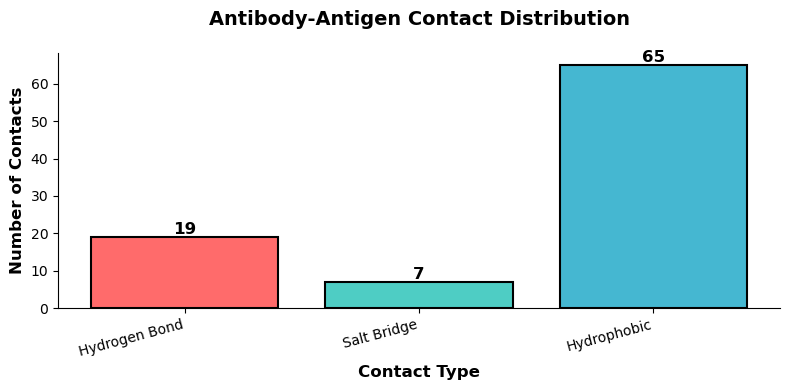

In [12]:
import matplotlib.pyplot as plt

# Prepare data for plotting
contact_types = [ct.value.replace('_', ' ').title() for ct in counts.keys()]
contact_counts = list(counts.values())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

# Create bar plot
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(contact_types, contact_counts, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Contacts', fontsize=12, fontweight='bold')
ax.set_xlabel('Contact Type', fontsize=12, fontweight='bold')
ax.set_title('Antibody-Antigen Contact Distribution', fontsize=14, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## 5. Detailed Contact Analysis

### 5.1 Top Interface Residues

Identify residues with the most contacts.

In [13]:
# Get residue summary
residue_summary = contact_output.get_residue_summary()

# Sort by total contacts
sorted_residues = sorted(residue_summary.items(), 
                         key=lambda x: x[1]['total'], 
                         reverse=True)

print("=" * 80)
print("TOP 10 INTERFACE RESIDUES (by total contact count)".center(80))
print("=" * 80)
print(f"{'Rank':<6}{'Residue':<15}{'Total':<8}{'H-bonds':<10}{'Salt':<8}{'Hydrophobic':<12}{'Partners'}")
print("-" * 80)

for i, (res_id, data) in enumerate(sorted_residues[:10], 1):
    hbond = data.get('hydrogen_bond', 0)
    salt = data.get('salt_bridge', 0)
    hydro = data.get('hydrophobic', 0)
    total = data.get('total', 0)
    partners = ', '.join(data.get('partners', [])[:2])  # Show first 2 partners
    if len(data.get('partners', [])) > 2:
        partners += f" +{len(data['partners'])-2} more"
    
    print(f"{i:<6}{res_id:<15}{total:<8}{hbond:<10}{salt:<8}{hydro:<12}{partners}")

print("=" * 80)

               TOP 10 INTERFACE RESIDUES (by total contact count)               
Rank  Residue        Total   H-bonds   Salt    Hydrophobic Partners
--------------------------------------------------------------------------------
1     PHE H:102      19      0         0       19          PRO A:53, ALA A:51 +1 more
2     TYR L:34       16      2         0       14          LEU A:98, VAL A:34 +3 more
3     VAL A:34       14      0         0       14          TYR L:34, PHE H:102
4     PRO A:53       14      0         0       14          TYR L:34, PHE H:102 +1 more
5     PRO A:59       14      0         0       14          ILE H:50, TYR H:32 +1 more
6     LEU A:98       14      1         0       13          TYR L:57, TYR L:34 +3 more
7     TYR L:57       10      0         0       10          LEU A:98, ALA A:99
8     TYR H:32       8       1         0       7           LYS A:48, PRO A:59
9     ARG H:98       8       4         4       0           ASP A:55, SER A:57
10    ASP A:55       7    

### 5.2 Hydrogen Bond Analysis

Examine hydrogen bonding patterns in detail.

In [14]:
# Filter hydrogen bonds
hbonds = contact_output.filter_by_type(contactanalysis.ContactType.HYDROGEN_BOND)

print("=" * 90)
print(f"HYDROGEN BONDS ({len(hbonds)} total)".center(90))
print("=" * 90)
print(f"{'#':<4}{'Residue 1':<18}{'Atom 1':<10}{'Residue 2':<18}{'Atom 2':<10}{'Distance (Å)':<12}")
print("-" * 90)

for i, hb in enumerate(hbonds[:15], 1):  # Show first 15
    res1 = hb.residue1_id
    res2 = hb.residue2_id
    atom1 = hb.atom1.name.strip()
    atom2 = hb.atom2.name.strip()
    dist = hb.distance
    
    print(f"{i:<4}{res1:<18}{atom1:<10}{res2:<18}{atom2:<10}{dist:<12.3f}")

if len(hbonds) > 15:
    print(f"... and {len(hbonds)-15} more")
print("=" * 90)

                                HYDROGEN BONDS (19 total)                                 
#   Residue 1         Atom 1    Residue 2         Atom 2    Distance (Å)
------------------------------------------------------------------------------------------
1   TYR H:32          OH        LYS A:48          NZ        2.989       
2   TYR H:34          OH        SER A:57          O         2.713       
3   ASN H:58          ND2       SER A:57          O         3.072       
4   ARG H:98          NH1       ASP A:55          OD1       2.864       
5   ARG H:98          NH1       ASP A:55          OD2       3.497       
6   ARG H:98          NH1       SER A:57          OG        2.777       
7   ARG H:98          NH2       ASP A:55          OD2       2.804       
8   TYR H:100         O         LYS A:48          NZ        2.806       
9   TYR H:100         OH        THR A:46          O         3.387       
10  TYR H:100         OH        THR A:46          OG1       2.890       
11  ARG H:101  

### 5.3 Salt Bridge Analysis

Electrostatic interactions between charged residues.

In [15]:
# Filter salt bridges
salt_bridges = contact_output.filter_by_type(contactanalysis.ContactType.SALT_BRIDGE)

print("=" * 85)
print(f"SALT BRIDGES ({len(salt_bridges)} total)".center(85))
print("=" * 85)
print(f"{'#':<4}{'Positive Residue':<20}{'Negative Residue':<20}{'Distance (Å)':<15}{'Pair Type':<15}")
print("-" * 85)

for i, sb in enumerate(salt_bridges, 1):
    # Determine which is positive/negative
    if sb.atom1.resname in ['LYS', 'ARG']:
        pos_res = sb.residue1_id
        neg_res = sb.residue2_id
    else:
        pos_res = sb.residue2_id
        neg_res = sb.residue1_id
    
    dist = sb.distance
    pair_type = sb.metadata.get('charge_pair', 'N/A')
    
    print(f"{i:<4}{pos_res:<20}{neg_res:<20}{dist:<15.3f}{pair_type:<15}")

print("=" * 85)

# Summary of unique salt bridge pairs
unique_pairs = {}
for sb in salt_bridges:
    pair = tuple(sorted([sb.residue1_id, sb.residue2_id]))
    if pair not in unique_pairs:
        unique_pairs[pair] = []
    unique_pairs[pair].append(sb.distance)

print(f"\n{'Unique residue-residue salt bridges:':<40}{len(unique_pairs)}")

                                SALT BRIDGES (7 total)                               
#   Positive Residue    Negative Residue    Distance (Å)   Pair Type      
-------------------------------------------------------------------------------------
1   ARG H:98            ASP A:55            2.864          ARG-ASP        
2   ARG H:98            ASP A:55            3.497          ARG-ASP        
3   ARG H:98            ASP A:55            3.685          ARG-ASP        
4   ARG H:98            ASP A:55            2.804          ARG-ASP        
5   LYS H:135           GLU L:217           3.795          LYS-GLU        
6   LYS H:215           GLU L:127           3.739          LYS-GLU        
7   LYS A:101           GLU L:59            2.890          LYS-GLU        

Unique residue-residue salt bridges:    4


### 5.4 Residue Partnership Network

Examine which residues interact with each other.

In [16]:
# Example: Get partners for a specific residue
example_residue = "PHE H:102"

partners = contact_output.get_residue_partners(example_residue)

print("=" * 80)
print(f"INTERACTION PARTNERS FOR {example_residue}".center(80))
print("=" * 80)

if partners:
    for partner_res, interactions in partners.items():
        print(f"\n{partner_res}:")
        print(f"  {'Atom Pair':<20}{'Contact Type':<25}{'Distance (Å)':<15}")
        print("  " + "-" * 70)
        for atom_pair, contact_type, distance in interactions:
            print(f"  {atom_pair:<20}{contact_type.value:<25}{distance:<15.3f}")
else:
    print(f"No interaction partners found for {example_residue}")

print("=" * 80)


                       INTERACTION PARTNERS FOR PHE H:102                       

VAL A:34:
  Atom Pair           Contact Type             Distance (Å)   
  ----------------------------------------------------------------------
  CB-CG2              hydrophobic              4.080          
  CG-CB               hydrophobic              4.358          
  CG-CG1              hydrophobic              3.983          
  CG-CG2              hydrophobic              4.060          
  CD1-CB              hydrophobic              3.940          
  CD1-CG1             hydrophobic              3.806          
  CD1-CG2             hydrophobic              3.937          
  CD2-CG1             hydrophobic              4.099          
  CE1-CB              hydrophobic              4.165          
  CE1-CG1             hydrophobic              3.775          
  CE2-CG1             hydrophobic              4.061          
  CZ-CG1              hydrophobic              3.905          

ALA A:51:
  Ato

## 6. Export to DataFrame

Convert contacts to pandas DataFrame for further analysis.

In [17]:
df = contact_output.to_dataframe()

print(f"DataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nColumn names:")
print(list(df.columns))
print("\nFirst 10 rows:")
df.head(10)

DataFrame shape: 91 rows × 13 columns

Column names:
['contact_type', 'atom1_id', 'atom2_id', 'atom1_name', 'atom2_name', 'residue1', 'residue2', 'resname1', 'resname2', 'chain1', 'chain2', 'distance', 'charge_pair']

First 10 rows:


,contact_type,atom1_id,atom2_id,atom1_name,atom2_name,residue1,residue2,resname1,resname2,chain1,chain2,distance,charge_pair
0,hydrogen_bond,H:32.OH,A:48.NZ,OH,NZ,TYR H:32,LYS A:48,TYR,LYS,H,A,2.989050,NaN
1,hydrogen_bond,H:34.OH,A:57.O,OH,O,TYR H:34,SER A:57,TYR,SER,H,A,2.713097,NaN
2,hydrogen_bond,H:58.ND2,A:57.O,ND2,O,ASN H:58,SER A:57,ASN,SER,H,A,3.071835,NaN
3,hydrogen_bond,H:98.NH1,A:55.OD1,NH1,OD1,ARG H:98,ASP A:55,ARG,ASP,H,A,2.863767,NaN
4,hydrogen_bond,H:98.NH1,A:55.OD2,NH1,OD2,ARG H:98,ASP A:55,ARG,ASP,H,A,3.497104,NaN
5,hydrogen_bond,H:98.NH1,A:57.OG,NH1,OG,ARG H:98,SER A:57,ARG,SER,H,A,2.777207,NaN
6,hydrogen_bond,H:98.NH2,A:55.OD2,NH2,OD2,ARG H:98,ASP A:55,ARG,ASP,H,A,2.804464,NaN
7,hydrogen_bond,H:100.O,A:48.NZ,O,NZ,TYR H:100,LYS A:48,TYR,LYS,H,A,2.805913,NaN
8,hydrogen_bond,H:100.OH,A:46.O,OH,O,TYR H:100,THR A:46,TYR,THR,H,A,3.387155,NaN
9,hydrogen_bond,H:100.OH,A:46.OG1,OH,OG1,TYR H:100,THR A:46,TYR,THR,H,A,2.889932,NaN


### Distance Distribution Analysis

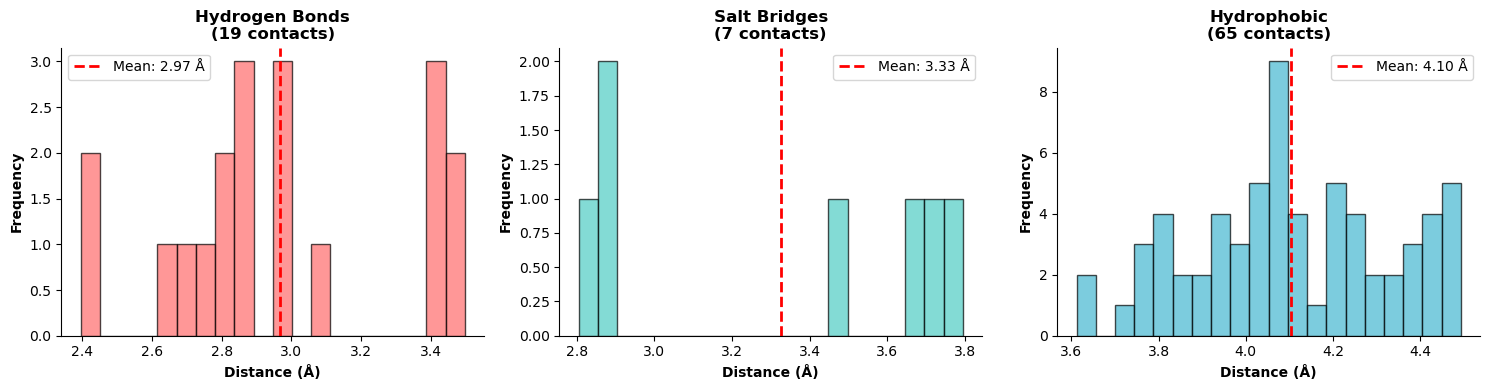

In [18]:
# Analyze distance distributions by contact type
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

contact_types_to_plot = [
    (contactanalysis.ContactType.HYDROGEN_BOND, 'Hydrogen Bonds', '#FF6B6B'),
    (contactanalysis.ContactType.SALT_BRIDGE, 'Salt Bridges', '#4ECDC4'),
    (contactanalysis.ContactType.HYDROPHOBIC, 'Hydrophobic', '#45B7D1')
]

for ax, (ctype, title, color) in zip(axes, contact_types_to_plot):
    contacts = contact_output.filter_by_type(ctype)
    distances = [c.distance for c in contacts]
    
    if distances:
        ax.hist(distances, bins=20, color=color, edgecolor='black', alpha=0.7)
        ax.axvline(sum(distances)/len(distances), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {sum(distances)/len(distances):.2f} Å')
        ax.set_xlabel('Distance (Å)', fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title(f'{title}\n({len(distances)} contacts)', fontweight='bold')
        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## 7. Chain-Specific Analysis

Break down contacts by chain to understand binding interface composition.

In [19]:
# Count interface residues per chain
chain_residues = {'H': [], 'L': [], 'A': []}

for res_id, data in residue_summary.items():
    chain = res_id.split()[-1].split(':')[0]  # Extract chain ID
    if chain in chain_residues:
        chain_residues[chain].append((res_id, data['total']))

print("=" * 70)
print("INTERFACE RESIDUES BY CHAIN".center(70))
print("=" * 70)

for chain in ['H', 'L', 'A']:
    residues = chain_residues[chain]
    total_contacts = sum(count for _, count in residues)
    
    chain_name = {
        'H': 'Heavy Chain (Antibody)',
        'L': 'Light Chain (Antibody)',
        'A': 'Antigen'
    }[chain]
    
    print(f"\nChain {chain} - {chain_name}")
    print("-" * 70)
    print(f"  Interface residues: {len(residues)}")
    print(f"  Total contacts:     {total_contacts}")
    
    if residues:
        avg_contacts = total_contacts / len(residues)
        print(f"  Avg contacts/res:   {avg_contacts:.1f}")
        
        # Top 3 residues
        top_residues = sorted(residues, key=lambda x: x[1], reverse=True)[:3]
        print(f"  Top 3 residues:")
        for res_id, count in top_residues:
            print(f"    • {res_id}: {count} contacts")

print("=" * 70)

                     INTERFACE RESIDUES BY CHAIN                      

Chain H - Heavy Chain (Antibody)
----------------------------------------------------------------------
  Interface residues: 11
  Total contacts:     57
  Avg contacts/res:   5.2
  Top 3 residues:
    • PHE H:102: 19 contacts
    • TYR H:32: 8 contacts
    • ARG H:98: 8 contacts

Chain L - Light Chain (Antibody)
----------------------------------------------------------------------
  Interface residues: 9
  Total contacts:     36
  Avg contacts/res:   4.0
  Top 3 residues:
    • TYR L:34: 16 contacts
    • TYR L:57: 10 contacts
    • LEU L:54: 3 contacts

Chain A - Antigen
----------------------------------------------------------------------
  Interface residues: 17
  Total contacts:     89
  Avg contacts/res:   5.2
  Top 3 residues:
    • VAL A:34: 14 contacts
    • PRO A:53: 14 contacts
    • PRO A:59: 14 contacts


## 8. Key Findings Summary

In [20]:
print("=" * 80)
print("KEY FINDINGS: ANTIBODY-ANTIGEN INTERFACE".center(80))
print("=" * 80)

print("\n📊 Overall Statistics:")
print(f"   • Total contacts detected: {len(contact_output.contacts)}")
print(f"   • Interface residues involved: {len(residue_summary)}")
print(f"   • Dominant interaction type: {max(counts.items(), key=lambda x: x[1])[0].value.replace('_', ' ').title()}")

print("\n🔬 Interaction Composition:")
for contact_type, count in counts.items():
    percentage = (count / sum(counts.values())) * 100
    print(f"   • {contact_type.value.replace('_', ' ').title():20s}: {count:3d} ({percentage:5.1f}%)")

print("\n⭐ Top Interface Residues:")
for i, (res_id, data) in enumerate(sorted_residues[:5], 1):
    print(f"   {i}. {res_id:15s} - {data['total']} contacts")

print("\n🔗 Strong Interactions:")
# Find strongest hydrogen bond
if hbonds:
    strongest_hb = min(hbonds, key=lambda x: x.distance)
    print(f"   • Closest H-bond: {strongest_hb.residue1_id} ↔ {strongest_hb.residue2_id} ({strongest_hb.distance:.2f} Å)")

# Salt bridges
if salt_bridges:
    print(f"   • {len(unique_pairs)} unique salt bridge pairs stabilize the interface")

print("\n" + "=" * 80)

                    KEY FINDINGS: ANTIBODY-ANTIGEN INTERFACE                    

📊 Overall Statistics:
   • Total contacts detected: 91
   • Interface residues involved: 37
   • Dominant interaction type: Hydrophobic

🔬 Interaction Composition:
   • Hydrogen Bond       :  19 ( 20.9%)
   • Salt Bridge         :   7 (  7.7%)
   • Hydrophobic         :  65 ( 71.4%)

⭐ Top Interface Residues:
   1. PHE H:102       - 19 contacts
   2. TYR L:34        - 16 contacts
   3. VAL A:34        - 14 contacts
   4. PRO A:53        - 14 contacts
   5. PRO A:59        - 14 contacts

🔗 Strong Interactions:
   • Closest H-bond: TYR L:34 ↔ PHE A:33 (2.40 Å)
   • 4 unique salt bridge pairs stabilize the interface



## END